# Activation Functions in Deep CNN–RNN Models  
## ReLU vs. Leaky ReLU under Increasing Depth

**Author:** Haoxuan Lin  
**Course:** NYU-DLFL25U – Introduction to Deep Learning (Undergraduate)  
**Semester:** Fall 2025

## Abstract

In this project, we study how the choice of activation function affects gradient flow and performance in deep neural networks. Using a controlled CNN–RNN architecture on an MNIST digit-to-word prediction task, we compare ReLU and Leaky ReLU under increasing network depth. We show that ReLU suffers from gradient attenuation and dead activations as depth increases, while Leaky ReLU significantly stabilizes training and improves end-to-end accuracy. Our results highlight the importance of activation function choice in deep sequence prediction models.


## 1. Introduction & Research Question

Deep neural networks rely on nonlinear activation functions to enable expressive representations. Among them, ReLU is widely adopted due to its simplicity and favorable optimization properties. However, ReLU is known to suffer from the *dying ReLU* problem, particularly in deep networks, where neurons can become inactive and stop contributing to learning.

In this project, we investigate the following research question:

**How does activation function choice (ReLU vs. Leaky ReLU) affect gradient flow and performance as network depth increases in an end-to-end CNN–RNN model?**

To answer this question, we design a controlled experimental setup that isolates depth as the primary variable while keeping other architectural factors fixed.


In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

# Use this constant to decide on which device to run the training - On Colab 'cuda:0' and 'cpu' refers to GPU and CPU respectively
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set the random seed for reproducibility
seed = 31
torch.manual_seed(seed)
np.random.seed(seed)

## Data loading
---

This code snippet sets up data pre-processing and creates data loaders for training and testing using the MNIST data set, which is commonly used for hand-written digit classification tasks in machine learning.

`DataLoader`s abstract outs the loading of a data set and iterating batches of the loaded data set. You can read the documentation to learn more about `DataLoader`s and `Dataset`s [`DataLoader`s and `Dataset`s](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
# Batch options
batch_size = 128  # input batch size for training
test_batch = 1    # test batch size

# Normalizes the input images for a better training
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

# Get train and test loaders to load MNIST data
trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

# Create the dataloaders on which we can iterate to get the data in batch_size chunks
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=test_batch, shuffle=False, num_workers=0)

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]


# 1 Preprocessing(no logical change, only changed to fit the expression)
## 1.1 Auxiliary data creation
---
First, let's setup `labels` and `vocab` for our problem statement. For this,
1. MNIST data set, consists of images and their corresponding labels of the form `{0, 1, 2, …}`.
First let's build a list mapping labels to `<b>` $\phi$ `<e>`, where $\phi \in \lbrace \texttt{zero}, \texttt{one}, \texttt{two}, \ldots , \texttt{nine}\rbrace$.

2. Build a lookup table for each unique tokens in the strings. Your `vocab` list, before sorting, should look like: `['<b>', 'z', 'e', 'r', 'o', '<e>', …]`.

Next, complete the following two functions:
1.   `label_to_onehot_sequence()` to convert a label to its one-hot sequence, representing the sequence of tokens. You may want to look at [`functional.one_hot` documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) for reference.
2. and `token_idx_to_token()` to convert the list of token indices to their corresponding string of characters.

The functions below are heavily annotated so that you understand what each function is doing and how can you use them for your use case.
The `assert` is a simple way for testing the correctness of your implementation.

In [ ]:
digits = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
prefix, suffix = '<b>', '<e>'
# Create list and Lookup Table ###########################################
# TODO📝: labels = list of sequences of tokens such that it converts
#       label to digit into strings.
# TODO📝: vocab = list of all the unique tokens in labels.
################################################################################
#raise NotImplementedError("Please implement the code to create the labels and vocab")
labels = [prefix + d + suffix for d in digits]
print(labels)

tokens_unsorted = []
for lab in labels:
    toks = re.findall(r'<b>|<e>|[a-z]', lab)
    for t in toks:
        if t not in tokens_unsorted:
            tokens_unsorted.append(t)

vocab = sorted(tokens_unsorted)
print(vocab)

labelDict = {i: labels[i] for i in range(len(labels))}

vocab_size = len(vocab)
word_size = max([len(digit) for digit in digits]) + 2 # +2 for prefix and suffix

# Testing that your lookup tables are setup correctly
assert(vocab_size == 17)
assert(len(labelDict) == 10)

['<b>zero<e>', '<b>one<e>', '<b>two<e>', '<b>three<e>', '<b>four<e>', '<b>five<e>', '<b>six<e>', '<b>seven<e>', '<b>eight<e>', '<b>nine<e>']
['<b>', '<e>', 'e', 'f', 'g', 'h', 'i', 'n', 'o', 'r', 's', 't', 'u', 'v', 'w', 'x', 'z']


In [ ]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
# Some utility functions to check if your code is working as intended
def assert_encoding(actual, expected):
  assert(type(actual) == type(torch.tensor(0))) # Your output is not of type tensor, please ensure that your function should output tensors
  if(not((expected.numpy() == actual.numpy()).all())):
    print('expected: ', expected)
    print('actual: ', actual)
    assert((expected.numpy() == actual.numpy()).all())

# Get the index of a token in the vocab
def get_idx(letter):
    return vocab.index(letter)
################################################################################

In [ ]:
# Function to convert a list of labels to a list of one-hot matrix
def label_to_onehot_sequence(label):
    label_index = label.item() # Get the label
    tokens = re.findall(r'<b>|<e>|[a-z]', labels[label_index])
    # Map label -> one-hot sequence ############################################
    # TODO📝: complete the function converting a single label to its corresponsing one-hot
    # in: 9 out: one-hot('<b>nine<e>')
    ############################################################################
    #raise NotImplementedError("label_to_onehot_sequence() not implemented")
    idxs = [get_idx(tok) for tok in tokens]
    idxs = torch.tensor(idxs, dtype=torch.long)
    onehot = torch.nn.functional.one_hot(idxs, num_classes=vocab_size).to(torch.float32)
    return onehot



assert_encoding(label_to_onehot_sequence(torch.tensor(3)),
  torch.tensor([[
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   # <b>
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],   #  t
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  h
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],   #  r
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  e
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  e
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], # <e>
    dtype=torch.float32))

In [ ]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
def batch_of_labels_to_onehot_matrix(labels):
    # Convert labels to one-hot tensors
    onehot_inputs = [label_to_onehot_sequence(label) for label in labels]

    # Pad the length of string since, matrix operation requires fixed-size rows
    max_len = max(len(onehot) for onehot in onehot_inputs)
    padded_onehot = pad_sequence(onehot_inputs, batch_first=True, padding_value= 0)
    return max_len, padded_onehot

# Convert label to label onehot - used in the next to feed argmax input to RNN
def label_to_onehot(target):
    return F.one_hot(target, num_classes=10).to(torch.float32)
################################################################################

In [ ]:
# To convert token indices predicted by our model back to characters and form the word
def token_idx_to_token(input):

    # Convert list of token idx to '<b>φ<e>' ##################################
    # TODO📝: complete the function to convert a list of token indices to the format '<b>φ<e>'
    # For each index in the input list, get the corresponding token from vocab, to build the output word
    # example input -> [ 0, 3, 6, 13, 2,  1] -> '<b>five<e>'
    #                    ⬇ ⬇ ⬇   ⬇ ⬇  ⬇
    #                   <b> f  i   v  e  <e>
    #raise NotImplementedError("token_idx_to_token() not implemented")
    output = ''
    for idx in input:
        output += vocab[idx]
    return output

assert(token_idx_to_token([0, 3,  6, 13,  2,  1]) == '<b>five<e>')

## 1.2 Data Exploration
---
1. Write code to fetch a batch from the `train_loader` and display the first 10 images along with their respective sequence of tokens which will be of the form `<b>` $\phi$ `<e>`, where $\phi \in \lbrace \texttt{zero}, \texttt{one}, \texttt{two}, \ldots, \texttt{nine}\rbrace$.

Use `matplotlib` and Jupyter notebook's visualisation capabilities. See this [PyTorch tutorial page](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for hints on how display images.

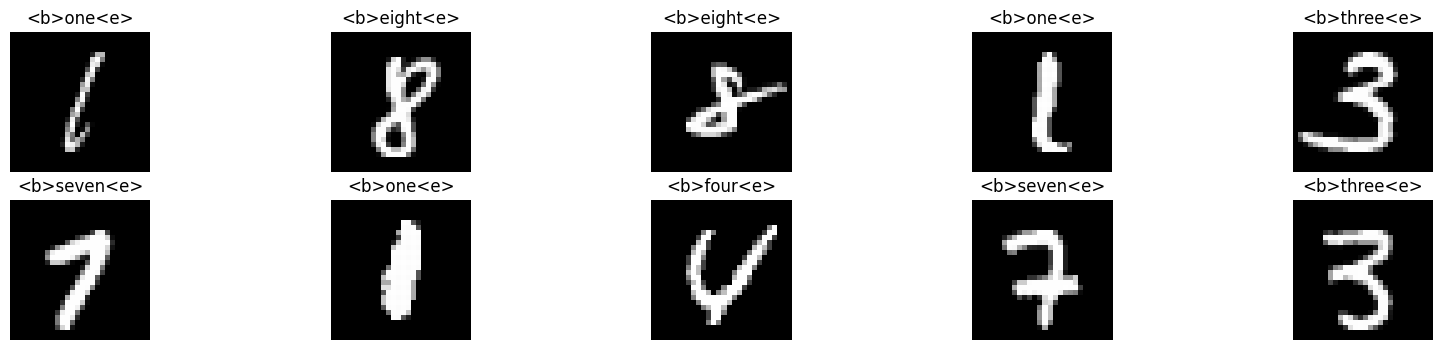

In [ ]:
# Visualise the dataset images #################################################
# TODO📝: Fetch a batch from the train_loader and display the first 10 images along
#       with the label and the respective token sequence of the form <b>φ<e>
################################################################################
def visualise_images(train_loader, num_images=10):
    images, labels_batch = next(iter(train_loader))

    plt.figure(figsize=(20, 4))

    for i in range(num_images):
        img = images[i].squeeze().numpy()
        lbl = labels[labels_batch[i].item()]  # '<b>zero<e>' etc.

        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(lbl)
    plt.show()


# Call the function to visualize the images along with the label
visualise_images(train_loader)  # Assuming `train_loader` is your DataLoader object

## Training and Validation Functions
---

In [ ]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
# Utility function to print statistics for debugging as well as modifies target and output for accuracy calculation
def trainUtility(batch_idx, epoch, output, target, padded_onehot):
    # Printing statistics for easy debugging
    if batch_idx == 1 or (epoch != None and epoch%500==0):
        _, pred_idx = torch.max(output, dim=-1)
        _, true_idx = torch.max(padded_onehot[:, 1:, :], dim=-1)
        print('acc: ', torch.sum(pred_idx == true_idx)/(pred_idx.shape[0]*pred_idx.shape[1]))
        print(pred_idx[0, :], true_idx[0, :])

    # Converting output of size (batch_size x max_word_length-1 x vocab_size) -> ((batch_size*(max_word_length-1)) x vocab_size)
    output =  output.view(-1, vocab_size)
    # Converting the true labels to ((batch_size*(max_word_length-1)) x vocab_size)
    # omitting the first character since, this is not getting predicted by the model
    target = padded_onehot[:, 1:, :].reshape(-1, vocab_size)

    return output, target
################################################################################

In [ ]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
# We will create a custom dataset for training our RNN in part 2.2, data will be a tuple of
# one-hot matrix for each label (batch_size x 10) and corresponding one-hot matrix of words (batch_size x max_word_length x vocab_size)
class RnnTrainingDataset(Dataset):
    """Dataset to get a tuple of one-hot matrix for each label (batch_size x 10)
       and corresponding one-hot matrix of words (batch_size x max_word_length - 1 x vocab_size)"""

    def __init__(self):
        """
        Arguments:
        """
        self.X = label_to_onehot(torch.tensor([x for x in range(10)]))
        _, self.Y = batch_of_labels_to_onehot_matrix(torch.tensor([x for x in range(10)]))


    def __len__(self):
        return 10 # There are only 10 words

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

rnn_dataset = RnnTrainingDataset()
rnn_dataloader = torch.utils.data.DataLoader(rnn_dataset, batch_size=10, shuffle=True)
rnn_testloader = torch.utils.data.DataLoader(rnn_dataset, batch_size=1, shuffle=True)
################################################################################

In [ ]:
# Function which does the training for number of epochs and model and type of model passed
def train(num_epochs, optimiser, model, dataloader=train_loader, mode='ENCODER'):
    model.to(device)
    model.train()
    crierion = None
    # Select Loss ##############################################################
    # TODO📝: criterion = loss function to classify into K classes
    ############################################################################
    if mode == 'ENCODER':
        criterion = nn.CrossEntropyLoss()
    elif mode == 'DECODER':
        criterion = nn.CrossEntropyLoss(ignore_index=0)
    elif mode == 'E2E' :
        criterion = nn.CrossEntropyLoss()
    elif mode == 'MODULAR':
        criterion = None

    lr_list = []
    for epoch in range(num_epochs):
      for batch_idx, (data, target) in enumerate(dataloader):
          data = data.to(device)
          target = target.to(device)

          if(mode == 'E2E'): # For 2.4 and 2.5 - CNN-RNN models
            # Convert labels to one-hot tensors
            _, padded_onehot = batch_of_labels_to_onehot_matrix(target) # Output size (batch_size x max_word_length x vocab_size)
            padded_onehot = padded_onehot.to(device)

            output = model(data, padded_onehot)      # (B, max_len-1, vocab_size)

            # Forward pass #####################################################
            # TODO📝: output = forward pass of your model
            ####################################################################
            #raise NotImplementedError("Please implement the forward pass of your model")

            # Call trainUtility
            output, target = trainUtility(batch_idx, epoch, output, target, padded_onehot)

          elif(mode == 'ENCODER'): # For 2.1 - CNN classifier
            output = None
            # Forward pass #####################################################
            # TODO📝: output = forward pass of your model
            ####################################################################
            #raise NotImplementedError("Please implement the forward pass of your model")
            output = model(data)



          elif(mode == 'DECODER'): # For 2.2 - Overfitting RNN
            # Convert labels to one-hot tensors
            padded_onehot = target

            output = None
            # Forward pass #####################################################
            # TODO📝: output = forward pass of your model, you will not pass the
            #                  end token <e> to your model
            ####################################################################
            #raise NotImplementedError("Please implement the forward pass of your model")
            rnn_input_seq = padded_onehot[:, :-1, :]
            output = model(data, rnn_input_seq)
            # Call trainUtility
            output, target = trainUtility(batch_idx, epoch, output, target, padded_onehot)
            target_idx = torch.argmax(target, dim=1)

          elif mode == 'MODULAR':
                continue
          else:
                raise ValueError(f"Unknown mode: {mode}")

          loss = None
          # Loss computation ###################################################
          # TODO📝: loss = evaluate the criterion on the model output
          ######################################################################
          if mode == 'ENCODER':
              loss = criterion(output, target)
          elif mode == 'DECODER':
                loss = criterion(output, target_idx)
          elif mode == 'E2E':
              logp = F.log_softmax(output, dim=1)
              per_token_loss = -(target * logp).sum(dim=1)
              mask = (target.sum(dim=1) > 0).float()
              loss = (per_token_loss * mask).sum() / (mask.sum() + 1e-8)
          else:
              continue

          # Zero grad ##########################################################
          # TODO📝: zero grad the parameters
          ######################################################################
          #raise NotImplementedError("Zero grad the parameters")

          optimiser.zero_grad()

          # Compute gradients ##################################################
          # TODO📝: back-propogate loss to calculate the grad weights
          ######################################################################
          #raise NotImplementedError("Back-propogate loss to calculate the grad weights")
          loss.backward()


          #New: find the zero-rate of the neuron(to see how the calculate power is wasted.)
          with torch.no_grad():
              grad_mean = float('nan')
              zero_ratio = float('nan')

              if hasattr(model, "encoder"):
                  g1 = model.encoder.conv1.weight.grad
                  if g1 is not None:
                      grad_mean = g1.abs().mean().item()

                  mid_act = getattr(model.encoder, "last_mid_act", None)
                  if mid_act is not None and getattr(model.encoder, "act_name", "") == "relu":
                      zero_ratio = (mid_act == 0).float().mean().item()

              if (batch_idx + 1) % 200 == 0:
                  log_str = f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}"
                  if not np.isnan(grad_mean):
                      log_str += f" | CNN_Grad: {grad_mean:.2e} | ReLU_Dead: {zero_ratio:.2%}"
                  print(log_str)


          # Optimisation step ##################################################
          # TODO📝: perform a single optimization step (weight update)
          ######################################################################
          #raise NotImplementedError("Perform a single optimization step (weight update)")

          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimiser.step()

          if (batch_idx+1) % 500 == 0 or (mode == 'DECODER' and epoch%1000 == 0):
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, batch_idx+1, len(dataloader), loss.item()))

In [ ]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
def evaluate(model, dataloader=test_loader, mode='ENCODER'):
    # Never forget to change model to eval mode using eval(), this freezes the model weights for updates
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader:
        data = data.to(device)
        target = target.to(device)
        if(mode == 'ENCODER'):
          # Predicted output
          output = model(data)

          # Calculate correct prediction count
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        elif(mode == 'DECODER'):
          # Predicted output
          output = torch.tensor(model.sample(data), device=device)

          # True output
          _, true = torch.max(target, dim=-1)
          # Remove padding
          true = torch.tensor(np.concatenate(([0],np.delete(true.cpu().numpy(),
                                                            np.argwhere(true.cpu().numpy()==0)))), device=device)

          # Calculate correct prediction count
          print("Comparing output with true:", output.shape, true.shape)
          correct += torch.sum(output == true)/output.shape[0]
        elif(mode == 'MODULAR'):
          # Predicted output
          output = model.sample(data)

          # True output
          true = [labels[label.item()] for label in target]
          true_indices = [0] + [get_idx(c) for c in true[0][3:-3]] + [1]
          true = torch.tensor(true_indices)
          output = torch.tensor(output)
          true = torch.full(output.shape, 20) if output.shape[0] != true.shape[0] else true

          # Calculate correct prediction count
          correct += torch.sum(output == true)/output.shape[0]
        elif(mode == 'E2E'):
          # Predicted output
          output = torch.tensor(model.sample(data))

          # True output
          true = [labels[label.item()] for label in target]
          true_indices = [0] + [get_idx(c) for c in true[0][3:-3]] + [1]
          true = torch.tensor(true_indices)
          output = torch.tensor(output)
          true = torch.full(output.shape, 20) if output.shape[0] != true.shape[0] else true

          # Calculate correct prediction count
          correct += torch.sum(output == true)/output.shape[0]

    test_loss /= len(dataloader.dataset)
    print('\nTest set: Accuracy: {:.0f}/{} ({:.0f}%)\n'.format(
        correct, len(dataloader.dataset),
        100 * correct / len(dataloader.dataset)))

    return 100 * correct / len(dataloader.dataset)
################################################################################

# 2 Model Creation and Training
## 2.1 Convolutional Network Architecture

In this project, we systematically investigate the impact of **activation function design** on
gradient propagation, neuron sparsity, and training stability in deep convolutional encoders.
To this end, we modify the **CnnEncoder** by replacing the standard ReLU activation with different
variants from the ReLU family, while keeping all other architectural components unchanged.
This controlled setup allows us to isolate the effect of activation nonlinearity on model behavior.

Specifically, we consider the following three ReLU-family activation functions
used throughout the encoder.

---

### 1. ReLU

$$
\mathrm{ReLU}(x) =
\begin{cases}
0, & x \le 0, \\
x, & x > 0.
\end{cases}
$$

ReLU serves as the baseline activation, inducing sparse activations but potentially causing
gradient blockage in the negative input region.

---

### 2. Leaky ReLU

Let $\alpha > 0$ denote a small leakage coefficient.

$$
\mathrm{LeakyReLU}_{\alpha}(x) =
\begin{cases}
\alpha x, & x \le 0, \\
x, & x > 0.
\end{cases}
$$

Leaky ReLU mitigates the dead-neuron problem by allowing non-zero gradients in the negative regime,
thereby improving gradient flow during backpropagation.

---

### 3. Negative-Slope ReLU (Parametric Variant)

Let $\alpha \ge 0$ represent the magnitude of the negative slope applied to negative inputs.

$$
\mathrm{NegSlopeReLU}_{\alpha}(x) =
\begin{cases}
- \alpha x, & x \le 0, \\
x, & x > 0.
\end{cases}
$$

This variant explicitly inverts the sign of negative activations, introducing an alternative
gradient routing mechanism that alters feature symmetry and may affect representational dynamics.

> **Remark.**  
> If the negative branch instead applies a positive slope ($\alpha x$),
> this formulation reduces to Leaky ReLU.
> In our implementation, the sign and magnitude of the negative slope are treated
> as explicit design choices to study their influence on optimization behavior.

---

By comparing these activation functions under identical training conditions, the project aims to
analyze how activation nonlinearity shapes gradient flow, neuron utilization, and overall training
performance in convolutional neural networks.


In [ ]:
# options
#New: to make a more significant difference between different algos, I manually reduce the hyperparameters.
epochs = 5         # number of epochs to train
lr = 0.01           # learning rate

cnnEncoder = None
linearClassifier = None
# Convolutional net architecture ###############################################
# TODO📝: cnnEncoder = cnn model - input: image(batch_size x 1 x img_sz x img_sz)
#                                  output: (batch_size, 84)
# TODO📝: linearClassifier = linear classifier - input: (batch_size, 84)
#                                                output: (batch_size, 10)
################################################################################
#raise NotImplementedError("Please implement the CNN encoder and linear classifier")

class CnnEncoder(nn.Module):
    """
    Drop-in replacement for the original encoder.
    Keeps the same macro-structure, but inserts N middle conv layers
    at the (B,16,11,11) resolution to control depth.
    Output: (B,84) as before.
    """
    def __init__(self, act_name='relu', negative_slope=0.01, depth=0):
        super().__init__()
        self.act_name = act_name
        self.negative_slope = negative_slope
        self.depth = int(depth)

        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)    # 1x28x28 -> 6x26x26
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)       # 6x26x26 -> 6x13x13
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1)   # 6x13x13 -> 16x11x11

        # Inserted middle layers: keep shape (B,16,11,11)
        self.mid_layers = nn.ModuleList([
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
            for _ in range(self.depth)
        ])

        self.conv3 = nn.Conv2d(16, 120, kernel_size=3, stride=1) # 16x5x5 -> 120x3x3
        self.fc1   = nn.Linear(120 * 3 * 3, 84)
        self.norm = nn.LayerNorm(84)

        # for logging (optional)
        self.last_mid_act = None

    def act(self, x):
        if self.act_name == 'relu':
            return F.relu(x)
        elif self.act_name == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=self.negative_slope)
        elif self.act_name == 'neg_slope':
            return F.leaky_relu(x, negative_slope=self.negative_slope)
        else:
            raise ValueError(f"Unknown act_name: {self.act_name}")

    def forward(self, x):
        x = self.act(self.conv1(x))   # (B,6,26,26)
        x = self.pool(x)             # (B,6,13,13)
        x = self.act(self.conv2(x))  # (B,16,11,11)

        # Controlled depth block (the only thing you vary in main experiment)
        for layer in self.mid_layers:
            x = self.act(layer(x))
        self.last_mid_act = x.detach()  # activation AFTER nonlinearity

        x = self.pool(x)             # (B,16,5,5)
        x = self.act(self.conv3(x))  # (B,120,3,3)
        x = torch.flatten(x, 1)      # (B,1080)
        x = self.act(self.fc1(x))    # (B,84)
        x = self.norm(x)
        return x

cnnEncoder = CnnEncoder()
linearClassifier = nn.Linear(84, 10)

cnnClassifier = nn.Sequential(cnnEncoder, linearClassifier)
enc_optimiser = None
# Creating Optimiser ###########################################################
# TODO📝: enc_optimiser = create a SGD optimiser for the cnnClassifier
# TODO📝: Fill out the train() procedure for mode='ENCODER' in the previous section
################################################################################
#raise NotImplementedError("Please implement the SGD optimiser")

enc_optimiser = optim.SGD(cnnClassifier.parameters(), lr=lr)


train(epochs, enc_optimiser, cnnClassifier, mode='ENCODER')
acc = evaluate(cnnClassifier, test_loader, mode='ENCODER')

assert(acc > 50)

Epoch [1/5], Loss: 0.6209
Epoch [1/5], Loss: 0.4534
Epoch [2/5], Loss: 0.3692
Epoch [2/5], Loss: 0.1654
Epoch [3/5], Loss: 0.1415
Epoch [3/5], Loss: 0.2434
Epoch [4/5], Loss: 0.1297
Epoch [4/5], Loss: 0.1811
Epoch [5/5], Loss: 0.1054
Epoch [5/5], Loss: 0.1065

Test set: Accuracy: 9769/10000 (98%)



## 2.2 Recurrent net overfitting

In this section, we train a standalone recurrent neural network to **overfit the digit-to-word mapping**.
The goal here is **not generalization**, but rather to verify that the decoder architecture and training
procedure are implemented correctly.

Since the task consists of only ten possible digit names, a sufficiently expressive RNN should be able
to memorize the entire mapping with near-perfect accuracy. Successful overfitting therefore serves as
a sanity check before integrating the RNN with visual features.

The decoder is implemented as an LSTM that receives, at each time step, a concatenation of:
- the one-hot representation of the digit label, and
- the one-hot representation of the previously generated token.

During training, the end token `<e>` is excluded from the input sequence and used only as a prediction
target. During inference, tokens are generated autoregressively starting from the begin token `<b>`
until `<e>` is produced.


In [ ]:
# 1. RNN model for learning sequence of letters
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        # Create LSTM and Linear objects #######################################
        # TODO📝: self.lstm = LSTM object using input_size, hidden_size and num_layers,
        #                     set the batch_first option to True
        # TODO📝: self.fc = Linear layer to convert to get final output with size
        #                   (batch_size x vocab_size)
        ########################################################################
        #raise NotImplementedError("Please implement the LSTM and Linear layers")
        self.vocab_size = vocab_size
        self.lstm = nn.LSTM(
            input_size=vocab_size + input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, input, target):
        # input is batch of one-hot labels of shape (batch_size x 10)
        # target is one-hot of sequence of tokens without the last token and is of
        # shape (batch_size x max_word_length-1 x vocab_size)

        max_word_length = None

        # Setup ################################################################
        # TODO📝: Using target assign the three variables with the corresponding values of
        #         batch_size, max_word_length, and vocab_size
        ########################################################################
        #raise NotImplementedError("Please implement the setup of _, max_word_length and _")
        batch_size, max_word_length, vocab_size = target.shape


        #max_word_length += 1
        replicated_input = None
        rnn_input = None

        # Feed-forward behaviour of the model ##################################
        # In order to pass two inputs to our LSTM object, we need to concat input and target,
        # we will need to change (batch_size x 10) input matrix -> (batch_size x max_word_length-1 x 10)
        # TODO📝: replicated_input = repeat the one-hot input (max_word_length-1)
        #         times on 2nd dimension -> (batch_size x max_word_length-1 x 10)
        # TODO📝: rnn_input = concat the target with the replicated_input ->
        #         (batch_size x max_word_length-1 x vocab_size+10)
        #raise NotImplementedError("Feed-forward behaviour of the model")
        replicated_input = input.unsqueeze(1).repeat(1, max_word_length, 1)
        rnn_input = torch.cat((target, replicated_input), dim=2)

        out = None
        # TODO📝: out = write the feed-forward behaviour of the network
        ########################################################################
        #raise NotImplementedError("Please implement the feed-forward behaviour of the network")
        out, _ = self.lstm(rnn_input)
        out = self.fc(out)

        return out

    # Utility function to create next input_rnn using the current token and one-hot label(input)
    def create_concatenated_rnn_input(self, token_idx, input_digit):
        # input is single one-hot label of shape (1 x 10)
        # token_idx is a token index
        rnn_input = None
        # Create rnn_input of (1 x 1 x vocab_size+10) ##########################
        # TODO📝: rnn_input = matrix of (1 x 1 x vocab_size+10), which is the concatenation
        #         of the input and the one-hot vector corresponding to the token idx
        ########################################################################
        #raise NotImplementedError("Please implement the rnn_input creation")


        # input_digit: (1, 10)
        # token_idx: scalar int
        # (1,) -> one-hot (1, vocab_size)
        if isinstance(token_idx, torch.Tensor):
            token_idx = token_idx.item()

        token_onehot = F.one_hot(
        torch.tensor([token_idx], device=input_digit.device),
        num_classes=vocab_size
        ).to(torch.float32)

        rnn_input = torch.cat([token_onehot.unsqueeze(1), input_digit.unsqueeze(1)], dim=2)
        return rnn_input

    # This function samples next token given the <b> token until the <e> token
        # This function samples next token given the <b> token until the <e> token


    def sample(self, input):

        digit_idx = torch.argmax(input, dim=1).item()  # 0~9

        tokens = re.findall(r'<b>|<e>|[a-z]', labels[digit_idx])
        max_len = len(tokens)

        output = [get_idx('<b>')]
        rnn_input = self.create_concatenated_rnn_input(get_idx('<b>'), input)  # (1,1,V+10)
        hidden = None

        for _ in range(max_len - 1):
            out, hidden = self.lstm(rnn_input, hidden)   # out: (1,1,H)
            out = self.fc(out)                           # (1,1,V)
            out = out.squeeze(1)                         # (1,V)

            _, pred_idx = torch.max(out, dim=-1)         # (1,)
            idx = pred_idx.item()
            output.append(idx)

            rnn_input = self.create_concatenated_rnn_input(idx, input)

        return output




In [ ]:
# 2. Create an optimiser
# options
epochs = 5000         # number of epochs to train
lr = 0.05             # learning rate - TODO📝: set an appropriate lr
hidden_size = 8    # hidden size for rnn - TODO📝: set from 8, 16, 32, 64 - use the smallest one for which your model works
embed_size = 10       # input is onehot labels
num_layer = 1         # layers of rnn

rnnModel = None
dec_optimiser = None
# Recurrent net overfitting ####################################################
# TODO📝: rnnModel = DecoderRNN() model - input: one-hot label output: one-hot matrix of words
# TODO📝: dec_optimiser = create a SGD optimiser object
################################################################################
#raise NotImplementedError("Please implement the DecoderRNN and SGD optimiser")
rnnModel = DecoderRNN(input_size=embed_size,
                      hidden_size=hidden_size,
                      vocab_size=vocab_size,
                      num_layers=num_layer).to(device)

dec_optimiser = optim.SGD(rnnModel.parameters(), lr=lr)

train(epochs, dec_optimiser, rnnModel, mode='DECODER', dataloader=rnn_dataloader)
acc = evaluate(rnnModel, rnn_testloader, mode='DECODER')

assert(acc > 50)

acc:  tensor(0.0167, device='cuda:0')
tensor([10, 10, 10, 10, 10, 16], device='cuda:0') tensor([10,  2, 13,  2,  7,  1], device='cuda:0')
Epoch [1/5000], Step [1/1], Loss: 2.9146
acc:  tensor(0.1833, device='cuda:0')
tensor([2, 1, 1, 1, 1, 1], device='cuda:0') tensor([ 3,  8, 12,  9,  1,  0], device='cuda:0')
acc:  tensor(0.2333, device='cuda:0')
tensor([2, 2, 2, 2, 1, 1], device='cuda:0') tensor([10,  2, 13,  2,  7,  1], device='cuda:0')
Epoch [1001/5000], Step [1/1], Loss: 2.0497
acc:  tensor(0.4000, device='cuda:0')
tensor([8, 8, 8, 1, 1, 1], device='cuda:0') tensor([11, 14,  8,  1,  0,  0], device='cuda:0')
acc:  tensor(0.5333, device='cuda:0')
tensor([10,  7,  2,  1,  1,  1], device='cuda:0') tensor([8, 7, 2, 1, 0, 0], device='cuda:0')
Epoch [2001/5000], Step [1/1], Loss: 1.2837
acc:  tensor(0.6167, device='cuda:0')
tensor([7, 6, 7, 2, 1, 1], device='cuda:0') tensor([7, 6, 7, 2, 1, 0], device='cuda:0')
acc:  tensor(0.7333, device='cuda:0')
tensor([10,  6,  6,  1,  1,  1], device='

## 2.3 Modular approach

In this section, we combine the previously trained CNN classifier and RNN decoder in a **modular fashion**.
Both components are kept fixed, and no additional training is performed.

Given an input image, the CNN first predicts the digit class. The predicted digit is then converted
into a one-hot vector and passed to the RNN decoder, which generates the corresponding sequence of
character tokens.

This modular setup provides a reference point for later experiments. In particular, it allows us to
compare:
- fully modular inference,
- transfer learning with frozen visual features, and
- end-to-end trained CNN–RNN models.

Any performance gap between these approaches reflects the benefit (or limitation) of joint optimization
across visual and sequential components.

In [ ]:
# Modular approach #############################################################
# TODO📝: create a class as mentioned before
# TODO📝: combinationModel = instantiate your created class
################################################################################

class CombinationModel(nn.Module):
    def __init__(self, cnn, rnn): # Everything here is pretrained
        super(CombinationModel, self).__init__()
        self.cnn = cnn
        self.rnn = rnn

    def sample(self, image):
        self.cnn.eval()
        self.rnn.eval()
        with torch.no_grad():
            logits = self.cnn(image)                 # (1,10)
            pred_digit = torch.argmax(logits, dim=1) # (1,)
            digit_oh = label_to_onehot(pred_digit.cpu()).to(image.device)  # (1,10)

            pred_indices = self.rnn.sample(digit_oh)
        return pred_indices

combinationModel = CombinationModel(cnnClassifier, rnnModel)

acc = evaluate(combinationModel, test_loader, mode='MODULAR')

assert(acc > 50)


Test set: Accuracy: 9800/10000 (98%)



## 2.4 Transfer learning

We now consider a transfer learning setting in which the convolutional encoder is **frozen** and used
to extract image embeddings, while a sequence decoder is trained on top of these embeddings.

Specifically, the CNN encoder produces a fixed-length representation for each image, which is then
concatenated with the token sequence input and fed into an LSTM-based decoder. Only the decoder
parameters are updated during training.

This setup isolates the effect of sequence learning from visual feature learning. By keeping the
encoder fixed, we can assess how much of the final performance depends on:
- the quality of pretrained visual representations, versus
- joint optimization of visual and sequential components.

The transfer learning model also serves as an intermediate baseline between the modular approach
and the fully end-to-end trained architecture studied in the next section.

In [ ]:
# 1. RNN model for learning sequence of letters
class DecoderRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN2, self).__init__()
        # Initialisation of the class ##########################################
        # TODO📝: create LSTM and linear layer
        ########################################################################
        self.lstm = nn.LSTM(
            input_size=input_size + vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input):
        # Concatenated vector of image embedding and one-hot of the whole
        # sequence of tokens without the last one of size (batch_size x max_word_length-1 x vocab_size+embed_size)
        # Feed-forward behaviour ###############################################
        # TODO📝: write the feed-forward behaviour of the model
        ########################################################################
        out, _ = self.lstm(input)       # (B,T-1,H)
        out = self.fc(out)              # (B,T-1,V)
        return out

    def single_forward(self, input, hidden):
        # This function is called by DigitDecoder to output a single token given
        # the previous token along with the image embedding and the corresponding hidden tensor

        # Prediction behaviour #################################################
        # TODO📝: do a forward pass of the model
        # TODO📝: return output and new hidden
        ########################################################################
        out, hidden = self.lstm(input, hidden)  # (1,1,H)
        out = self.fc(out)                      # (1,1,V)
        return out, hidden

In [ ]:
# 2. Model to predict next words given the image
class DigitDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DigitDecoder, self).__init__()
        # Initialise the model #################################################
        # TODO📝: self.encoder = use the cnnEncoder
        # TODO📝: self.decoder = instantiation of DecoderRNN2
        ########################################################################
        self.encoder = cnnEncoder
        self.vocab_size = num_classes
        self.embed_size = input_size

        self.decoder = DecoderRNN2(
            input_size=input_size,
            hidden_size=hidden_size,
            vocab_size=num_classes,
            num_layers=num_layers
        )

    def forward(self, x, y):
        # Feed-forward behaviour of the model ##################################
        # TODO📝: try to emulate forward() from section 2.2
        # Some extra work is needed: calculate image embedding using
        # the self.encoder
        ########################################################################
        img_emb = self.encoder(x)             # (B, embed_size)
        y_in = y[:, :-1, :]                   # Target sequence WITHOUT <e> (B, T-1, V)
        Tm1 = y_in.size(1)

        img_emb_exp = img_emb.unsqueeze(1).repeat(1, Tm1, 1) # (B, T-1, embed_size)
        dec_in = torch.cat([img_emb_exp, y_in], dim=2)        # (B, T-1, embed+V)

        out = self.decoder(dec_in)            # (B, T-1, V)
        return out

    def sample(self, x):
        # Sampling the output string one token at a time #######################
        # TODO📝: try to emulate sample() method from section 2.2
        # Some extra work is needed: calculate image embedding using
        # the self.encoder
        ########################################################################
        self.eval()
        with torch.no_grad():
            img_emb = self.encoder(x)
            output = [get_idx('<b>')]
            hidden = None
            loopRun = 0

            while True and loopRun < 50:
                last_idx = output[-1]
                token_oh = F.one_hot(
                    torch.tensor([last_idx], device=x.device),
                    num_classes=self.vocab_size
                ).float()

                img_step = img_emb.unsqueeze(1)
                tok_step = token_oh.unsqueeze(1)

                dec_in = torch.cat([img_step, tok_step], dim=2)

                out, hidden = self.decoder.single_forward(dec_in, hidden)
                out = out.squeeze(1)
                _, pred_idx = torch.max(out, dim=-1)
                idx = pred_idx.item()
                output.append(idx)

                if idx == get_idx('<e>'):
                    break
                loopRun += 1
            return output

In [ ]:
# 3. and 4. model instantiation and optimiser creation
epochs = 2           # number of epochs to train
lr = 0.0001              # learning rate
hidden_size = 64    # hidden size for rnn - set from 8, 16, 32, 64 - use the smallest one for which your model works
num_layer = 1         # layers of rnn
embed_size = 84

tranferLearningModel = None
tra_optimiser = None
# Transfer learning ############################################################
# TODO📝: tranferLearningModel = create an object of DigitDecoder
# TODO📝: tra_optimiser = create a SGD optimiser object using just the DecoderRNN2 parameters
################################################################################
tranferLearningModel = DigitDecoder(
    input_size=embed_size,
    hidden_size=hidden_size,
    num_layers=num_layer,
    num_classes=vocab_size
).to(device)
for param in tranferLearningModel.encoder.parameters():
    param.requires_grad = False

tra_optimiser = optim.Adam(tranferLearningModel.decoder.parameters(), lr=lr)


train(epochs, tra_optimiser, tranferLearningModel, mode='E2E')
acc = evaluate(tranferLearningModel, test_loader, mode='E2E')

assert(acc > 50)

acc:  tensor(0.0208, device='cuda:0')
tensor([14, 14, 14, 14, 14, 14], device='cuda:0') tensor([10,  6, 15,  1,  0,  0], device='cuda:0')
acc:  tensor(0.0339, device='cuda:0')
tensor([16, 16, 16, 16, 16, 16], device='cuda:0') tensor([11,  5,  9,  2,  2,  1], device='cuda:0')
acc:  tensor(0.0365, device='cuda:0')
tensor([16, 16,  2,  2,  2,  2], device='cuda:0') tensor([11, 14,  8,  1,  0,  0], device='cuda:0')
acc:  tensor(0.0312, device='cuda:0')
tensor([16, 16, 16, 16, 16, 16], device='cuda:0') tensor([ 2,  6,  4,  5, 11,  1], device='cuda:0')
acc:  tensor(0.0365, device='cuda:0')
tensor([1, 1, 1, 1, 1, 1], device='cuda:0') tensor([10,  2, 13,  2,  7,  1], device='cuda:0')
acc:  tensor(0.0312, device='cuda:0')
tensor([16, 16, 16, 16, 16, 16], device='cuda:0') tensor([11, 14,  8,  1,  0,  0], device='cuda:0')
acc:  tensor(0.0430, device='cuda:0')
tensor([10, 10, 10, 10, 10, 10], device='cuda:0') tensor([ 2,  6,  4,  5, 11,  1], device='cuda:0')
acc:  tensor(0.0417, device='cuda:0')
te

/tmp/ipython-input-368580334.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(output)



Test set: Accuracy: 7842/10000 (78%)



## 2.5 End-to-end training
---
We investigate the effect of network depth and activation functions under an end-to-end CNN–RNN training setting.

Specifically, we vary the depth of the convolutional encoder by inserting additional convolutional layers between the second and third convolution blocks, while keeping all other architectural components fixed. The tested encoder depths are 0, 6, 12, and 30, corresponding to shallow, moderately deep, deep, and extremely deep plain convolutional networks, respectively.

For each depth configuration, we evaluate three activation functions:

ReLU,

Leaky ReLU with a small positive slope,

Negative-slope ReLU (non-monotonic variant).

In [ ]:
class DigitDecoder2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,
                 act_name='relu', depth=0, negative_slope=0.01):
        super(DigitDecoder2, self).__init__()

        self.encoder = CnnEncoder(act_name=act_name, depth=depth, negative_slope=negative_slope)

        self.vocab_size = num_classes
        self.embed_size = input_size

        self.decoder = DecoderRNN2(
            input_size=input_size,
            hidden_size=hidden_size,
            vocab_size=num_classes,
            num_layers=num_layers
        )

    def forward(self, x, y):

          img_emb = self.encoder(x)                # (B, embed_size)
          B, T, V = y.shape

          y_in = y[:, :-1, :]                      # (B, T-1, V)
          Tm1 = y_in.size(1)

          img_emb_exp = img_emb.unsqueeze(1).repeat(1, Tm1, 1)  # (B, T-1, embed_size)
          dec_in = torch.cat([img_emb_exp, y_in], dim=2)        # (B, T-1, embed_size + V)

          out = self.decoder(dec_in)               # (B, T-1, V)
          return out

    def sample(self, x):
          self.eval()
          with torch.no_grad():
              img_emb = self.encoder(x)            # (1, embed_size)

              output = [get_idx('<b>')]
              hidden = None
              loopRun = 0

              while True and loopRun < 50:
                  last_idx = output[-1]
                  token_oh = F.one_hot(
                      torch.tensor([last_idx], device=x.device),
                      num_classes=self.vocab_size
                  ).float()                        # (1, V)

                  img_step = img_emb.unsqueeze(1)  # (1, 1, embed_size)
                  tok_step = token_oh.unsqueeze(1) # (1, 1, V)
                  dec_in = torch.cat([img_step, tok_step], dim=2)  # (1, 1, embed_size + V)

                  out, hidden = self.decoder.single_forward(dec_in, hidden)  # out: (1,1,V)
                  out = out.squeeze(1)                  # (1, V)
                  _, pred_idx = torch.max(out, dim=-1)
                  idx = pred_idx.item()
                  output.append(idx)

                  if idx == get_idx('<e>'):
                      break

                  loopRun += 1

              return output

# options
epochs = 2       # number of epochs to train - TODO📝: set number of epochs
lr = 0.0001           # learning rate - TODO📝: set appropriate lr
hidden_size = 64  # hidden size for rnn - TODO📝: you may use the last lr
num_layer = 1    # layers of rnn - TODO📝: decide on number of layers to have in the rnn

# End-to-end training ##########################################################
# TODO📝: e2eModel = create an object of DigitDetector
# TODO📝: e2eOptimiser = create an optimiser object using DigitDetector parameters
################################################################################
#raise NotImplementedError("Please implement the DigitDecoder2 and SGD optimiser")

experiments = [
    {"name":"shallow_relu",    "act":"relu",       "depth":0,  "ns":0.001},
    {"name":"deep_relu",       "act":"relu",       "depth":6, "ns":0.001},
    {"name":"deep_leaky",      "act":"leaky_relu", "depth":6, "ns":0.001},
    {"name":"neg_slope",        "act":"neg_slope",        "depth":6, "ns":-0.001},
    {"name":"deep_relu",       "act":"relu",       "depth":12, "ns":0.001},
    {"name":"deep_leaky",      "act":"leaky_relu", "depth":12, "ns":0.001},
    {"name":"neg_slope",        "act":"neg_slope",        "depth":12, "ns":-0.001},
    {"name":"deep_relu",       "act":"relu",       "depth":30, "ns":0.001},
    {"name":"deep_leaky",      "act":"leaky_relu", "depth":30, "ns":0.001},
    {"name":"neg_slope",        "act":"neg_slope",        "depth":30, "ns":-0.001},


]

all_results = {}

for cfg in experiments:
    exp_key = f"{cfg['name']}_depth{cfg['depth']}"

    print(f"\nRunning Experiment: {exp_key}...")

    e2eModel = DigitDecoder2(
        input_size=embed_size,
        hidden_size=hidden_size,
        num_layers=num_layer,
        num_classes=vocab_size,
        act_name=cfg["act"],
        depth=cfg["depth"],
        negative_slope=cfg["ns"]
    ).to(device)

    e2eOptimiser = optim.Adam(e2eModel.parameters(), lr=lr)

    train(epochs, e2eOptimiser, e2eModel, mode='E2E')

    acc = evaluate(e2eModel, test_loader, mode='E2E')

    if torch.is_tensor(acc):
        acc = acc.item()
    all_results[exp_key] = acc

    print(f"{exp_key} finished. Acc: {acc:.2f}%")

print("\n" + "="*30)
print("       FINAL ACCURACY SUMMARY")
print("="*30)
for name, score in all_results.items():
    print(f"{name.ljust(20)} : {score:.2f}%")
print("="*30)


Running Experiment: shallow_relu_depth0...
acc:  tensor(0.0599, device='cuda:0')
tensor([5, 5, 5, 5, 5, 5], device='cuda:0') tensor([10,  6, 15,  1,  0,  0], device='cuda:0')
acc:  tensor(0.0560, device='cuda:0')
tensor([9, 9, 9, 9, 9, 9], device='cuda:0') tensor([7, 6, 7, 2, 1, 0], device='cuda:0')
acc:  tensor(0.0560, device='cuda:0')
tensor([9, 9, 9, 9, 9, 9], device='cuda:0') tensor([ 3,  6, 13,  2,  1,  0], device='cuda:0')
acc:  tensor(0.0990, device='cuda:0')
tensor([0, 8, 8, 8, 8, 8], device='cuda:0') tensor([ 3,  8, 12,  9,  1,  0], device='cuda:0')
acc:  tensor(0.1445, device='cuda:0')
tensor([2, 2, 2, 2, 2, 2], device='cuda:0') tensor([11, 14,  8,  1,  0,  0], device='cuda:0')
acc:  tensor(0.1875, device='cuda:0')
tensor([0, 1, 1, 1, 1, 1], device='cuda:0') tensor([ 3,  6, 13,  2,  1,  0], device='cuda:0')
acc:  tensor(0.1784, device='cuda:0')
tensor([0, 1, 1, 1, 1, 1], device='cuda:0') tensor([ 3,  6, 13,  2,  1,  0], device='cuda:0')
acc:  tensor(0.2005, device='cuda:0')


/tmp/ipython-input-368580334.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(output)


流式输出内容被截断，只能显示最后 5000 行内容。
acc:  tensor(0.3320, device='cuda:0')
tensor([7, 2, 2, 1, 1, 1], device='cuda:0') tensor([8, 7, 2, 1, 0, 0], device='cuda:0')
acc:  tensor(0.3242, device='cuda:0')
tensor([2, 2, 2, 2, 1, 1], device='cuda:0') tensor([7, 6, 7, 2, 1, 0], device='cuda:0')
acc:  tensor(0.3125, device='cuda:0')
tensor([6, 6, 1, 1, 1, 1], device='cuda:0') tensor([10,  6, 15,  1,  0,  0], device='cuda:0')
acc:  tensor(0.3216, device='cuda:0')
tensor([2, 2, 2, 2, 1, 1], device='cuda:0') tensor([11,  5,  9,  2,  2,  1], device='cuda:0')
acc:  tensor(0.3464, device='cuda:0')
tensor([8, 8, 1, 1, 1, 1], device='cuda:0') tensor([11, 14,  8,  1,  0,  0], device='cuda:0')
acc:  tensor(0.3320, device='cuda:0')
tensor([8, 8, 8, 1, 1, 1], device='cuda:0') tensor([11, 14,  8,  1,  0,  0], device='cuda:0')
acc:  tensor(0.3607, device='cuda:0')
tensor([8, 8, 8, 1, 1, 1], device='cuda:0') tensor([11, 14,  8,  1,  0,  0], device='cuda:0')
acc:  tensor(0.3516, device='cuda:0')
tensor([8, 8, 8, 1, 1, 

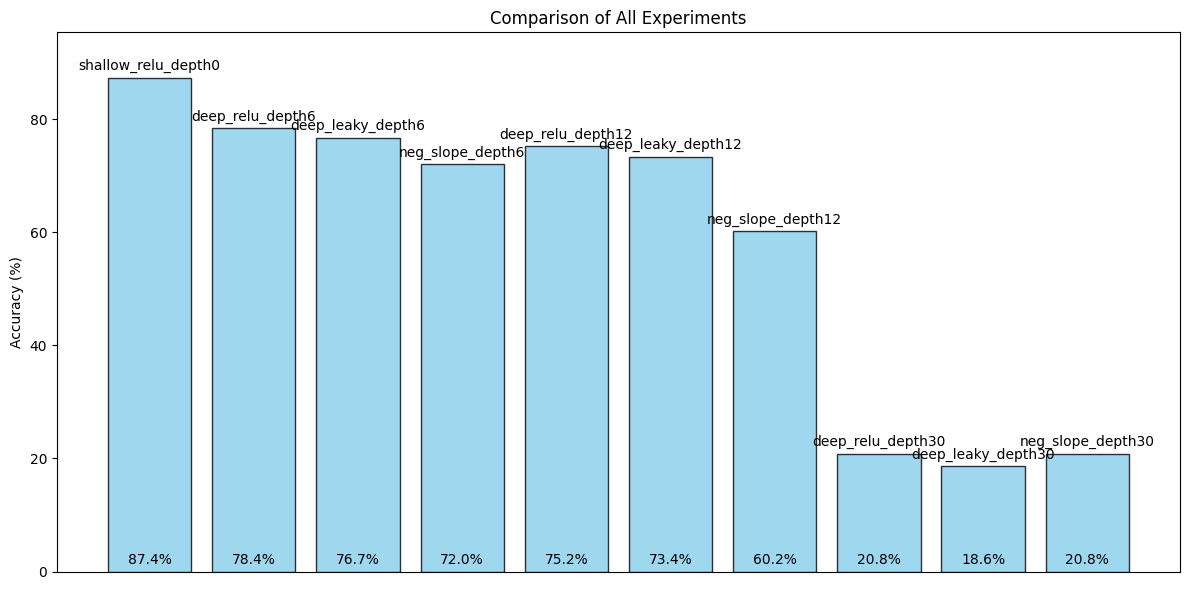

In [ ]:
import matplotlib.pyplot as plt

def plot_all_acc(results):
    names = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(names)), values, color='skyblue', edgecolor='black', alpha=0.8)

    plt.xticks([])

    for bar, name, val in zip(bars, names, values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        plt.text(x, y + 0.8, name, ha='center', va='bottom', fontsize=10)

        plt.text(x, 0.8, f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.ylim(0, max(values) + 8)
    plt.ylabel('Accuracy (%)')
    plt.title('Comparison of All Experiments')
    plt.tight_layout()
    plt.show()

plot_all_acc(all_results)
